In [9]:
import os
import sys
import pandas as pd
import numpy as np
from Bio import SeqIO, AlignIO
import seaborn as sns
from pathlib import Path
import sys
import atomium
sys.path.append('../../graph_toolbox/')
from feature import calc_named

### Truncate sequences

In [ ]:
fasta_input = list(SeqIO.parse('./all_filtered_from_singletons_and_noccds_vs_r751/all_filtered_from_singletons_and_noccds_vs_r751.fasta', 'fasta'))

In [ ]:
# for fasta in fasta_input:
#     if len(fasta.seq) > 150:
#         with open("./all_filtered_from_singletons_and_noccds_vs_r751/truncated_filtered_all.fasta", "a+") as handle:
#             SeqIO.write(fasta, handle, "fasta")


### Trim MSA

In [3]:
def trim_msa(msafile):
    alns = list(AlignIO.parse(msafile, 'fasta'))
    aln = alns[0]
    fs = np.asarray(list(str(aln[0].seq)))
    cols_to_keep = np.where(fs != '-')[0]
    new_aln = np.asarray([list(aln[:,int(c)]) for c in list(cols_to_keep)]).T
#     print(aln)
    seqids = list(SeqIO.parse(msafile, 'fasta'))

    ids = [record.id for record in seqids]
    with open(f"reformated_aln_{msafile.split('/')[-1].split('.')[0]}.aln", 'a') as out_file:
        for _id, alignment in zip(ids, new_aln):
            out_file.write(f'>{_id}\n')
            out_file.write(f"{''.join(alignment)}\n")
trim_msa(msafile = './all_filtered_from_singletons_and_noccds_vs_ra3/mafft_truncated_filtered_all_with_ra3_as_reference.msa')

### Parse al2co output

In [33]:
def parse_conservation_al2co(consfile: str) -> tuple:
    cons = pd.read_csv(consfile, skipfooter=14, engine='python', delim_whitespace=True, names=['pos', 'aa', 'score', 'gap'])
    cons = cons[cons.aa!='-'] # gaps in the master seq
    cons_seq = "".join(cons.aa.tolist())
    conserved_aa = cons.loc[cons['score'] > 0]
    conserved_aa['residue'] = conserved_aa.aa + conserved_aa.pos.astype(str)
    conserved_aa = conserved_aa.drop(['pos','aa','gap'], axis = 1)
    cols = conserved_aa.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    conserved_aa = conserved_aa[cols]
    conserved_aa = conserved_aa[['residue','score']]
    conserved_aa = dict(zip(conserved_aa['residue'].values, conserved_aa['score']*20))

#         new_cons = []
#         for my_seq_chunk in find_segments(self.data_row.seqres_index, self.data_row.seq):
#             pos = cons_seq.find(my_seq_chunk)
#             assert pos>=0, f'"{my_seq_chunk}" not found in "{cons_seq}"'
#             new_cons.append(cons.iloc[pos:pos+len(my_seq_chunk)])

#         cons = pd.concat(new_cons)
#         cons.reset_index(inplace=True)
#         cons_seq = "".join(cons.aa.tolist())
#         assert cons_seq == self.data_row.seq

#     for key, score in conserved_aa.items():
#         print(key, score)
    return cons_seq, conserved_aa
        
# parse_conservation_al2co('./all_filtered_from_singletons_and_noccds_vs_r751/all_filtered_al2co_conservation.txt')

### Parse pdb with bfactor set for conservation

In [57]:
def parse_pdb_conservation(pdbfile: str) -> tuple:
    df = PandasPdb().read_pdb(pdbfile)
    df.df['ATOM']['oneletteraa'] = df.amino3to1()['residue_name']
    df.df['ATOM'].ffill(inplace=True)
    onelettersequence = ''.join(df.amino3to1()['residue_name'])
#     print(onelettersequence)
    conserved_aa = df.df['ATOM'].loc[df.df['ATOM']['b_factor'] > 0]
    groupped = conserved_aa.groupby(['residue_number']).max()
    groupped['residue'] = groupped.oneletteraa + groupped.index.astype(str)
    truncated = groupped[['residue','b_factor']]
#     truncated.set_index('residue', inplace=True)
    truncated = dict(zip(truncated['residue'].values, truncated['b_factor']))
    
    return onelettersequence, truncated
parse_pdb_conservation('../md/hth_detached/map/contactmap_mapped_last.pdb')

('MAISKEQIFAVADELDAAGQNPTLANVRKQLGSGSFTTISEAMNEWRARKASQAAPIREPAPQAITDKLAELGGDLWAVALEMANNRLAAEREALEAVRQETEAARQEAAELADQLTGELDEAKARVAALEAVEAAAKGEADELRGKLAATSEMAISKEQIFAVADELDAAGQNPTLANVRKQLGSGSFTTISEAMNEWRARKASQAAPIREPAPQAITDKLAELGGDLWAVALEMANNRLAAEREALEAVRQETEAARQEAAELADQLTGELDEAKARVAALEAVEAAAKGEADELRGKLAATSE',
 {'A2': 0.1,
  'I3': 1.11,
  'S35': 4.96,
  'F36': 7.75,
  'T37': 4.76,
  'L69': 14.94,
  'A70': 51.3,
  'E71': 100.0,
  'G73': 14.94,
  'N239': 1.11,
  'E246': 17.22})

### Graph toolbox

In [15]:
f.model.residues()

{<Residue ALA (A.10)>,
 <Residue ALA (A.104)>,
 <Residue ALA (A.105)>,
 <Residue ALA (A.109)>,
 <Residue ALA (A.110)>,
 <Residue ALA (A.113)>,
 <Residue ALA (A.12)>,
 <Residue ALA (A.123)>,
 <Residue ALA (A.125)>,
 <Residue ALA (A.128)>,
 <Residue ALA (A.129)>,
 <Residue ALA (A.132)>,
 <Residue ALA (A.135)>,
 <Residue ALA (A.136)>,
 <Residue ALA (A.137)>,
 <Residue ALA (A.141)>,
 <Residue ALA (A.149)>,
 <Residue ALA (A.150)>,
 <Residue ALA (A.155)>,
 <Residue ALA (A.163)>,
 <Residue ALA (A.165)>,
 <Residue ALA (A.17)>,
 <Residue ALA (A.170)>,
 <Residue ALA (A.171)>,
 <Residue ALA (A.178)>,
 <Residue ALA (A.18)>,
 <Residue ALA (A.195)>,
 <Residue ALA (A.2)>,
 <Residue ALA (A.201)>,
 <Residue ALA (A.204)>,
 <Residue ALA (A.207)>,
 <Residue ALA (A.208)>,
 <Residue ALA (A.214)>,
 <Residue ALA (A.217)>,
 <Residue ALA (A.223)>,
 <Residue ALA (A.231)>,
 <Residue ALA (A.233)>,
 <Residue ALA (A.237)>,
 <Residue ALA (A.242)>,
 <Residue ALA (A.243)>,
 <Residue ALA (A.247)>,
 <Residue ALA (A.25)>,

In [23]:
f = atomium.open('test.pdb').model
pdb_list = list()
res = f.residue()
while res.previous is not None:
    res = res.previous
while res is not None:
    pdb_list.append(res.id)
    res = res.next

In [7]:
ls /home/users/rmadaj

anaconda3/  db/  deepcoilenv/  krfa/  lbs-tools/  mix.fasta  tmp/


In [8]:
# testfile = '../md/hth_attached/map/test.pdb'
testdf = calc_named(chain = None, pdb_loc = 'test.pdb', t = 9)

def prepare_df_from_toolbox(df: str) -> tuple:
    hth_residues = [x for x in range(0,70)]
    ccd_residues = [x for x in range(70,116)] + [x for x in range (223,265)]
    filtered_df = df[df['res1'].isin(hth_residues)]
    filtered_df = filtered_df[filtered_df['res2'].isin(ccd_residues)]
#     filtered_df = filtered_df.iloc[:, [0,1,2,3,4,5, -2,-1]]
    groupped = filtered_df.groupby(['res1','res2']).max()
    return groupped

    
    
prepare_df_from_toolbox(testdf)

disulfide  hydrophobic  cation_pi  arg_arg  salt_bridge  hbond  \
res1 res2                                                                   
0    86          0.0          0.0        1.0      0.0          0.0    0.0   
     239         0.0          0.0        1.0      0.0          0.0    0.0   
1    74          0.0          0.0        0.0      0.0          0.0    0.0   
     75          0.0          0.0        0.0      0.0          0.0    0.0   
     106         0.0          0.0        0.0      0.0          0.0    0.0   
...              ...          ...        ...      ...          ...    ...   
68   103         0.0          0.0        0.0      0.0          0.0    0.0   
     254         0.0          0.0        0.0      0.0          0.0    0.0   
     259         0.0          0.0        0.0      0.0          0.0    0.0   
69   89          0.0          0.0        0.0      0.0          0.0    0.0   
     256         0.0          0.0        0.0      0.0          0.0    0.0   

                   c    lj          e          cbcb   1/ca_ca  ca_vs_cb  self  \
res1 res2                                                                       
0    86    10.000000  10.0  10.000000  1.000000e-20  0.263725       0.0   0.0   
     239   10.000000  10.0  10.000000  9.894473e-01  0.111901       0.0   0.0   
1    74     0.874985   0.0   0.874985  9.790878e-01  0.115558       0.0   0.0   
     75     0.874985   0.0   0.874985  9.835494e-01  0.259861       0.0   0.0   
     106    0.874985   0.0   0.874985  1.031183e+00  0.180037       0.0   0.0   
...              ...   ...        ...           ...       ...       ...   ...   
68   103    2.657120   0.0   2.657120  9.938405e-01  0.140768       1.0   0.0   
     254    2.657120   0.0   2.657120  1.021846e+00  0.172302       0.0   0.0   
     259    2.657120   0.0   2.657120  9.887251e-01  0.254240       0.0   0.0   
69   89     1.100931   0.0   1.100931  1.000533e+00  0.162833       1.0   0.0   
     256    1.100931   0.0   1.100931  9.252550e-01  0.168367       1.0   0.0   

           is_seq  is_seq_not  is_struct  
res1 res2                                 
0    86       0.0         1.0        1.0  
     239      0.0         1.0        1.0  
1    74       0.0         1.0        1.0  
     75       0.0         1.0        1.0  
     106      0.0         1.0        1.0  
...           ...         ...        ...  
68   103      0.0         1.0        1.0  
     254      0.0         1.0        1.0  
     259      0.0         1.0        1.0  
69   89       0.0         1.0        1.0  
     256      0.0         1.0        1.0  

[236 rows x 16 columns]

,disulfide,hydrophobic,cation_pi,arg_arg,salt_bridge,hbond,c,lj,e,cbcb,dist,ca_vs_cb,self,is_seq,is_seq_not,is_struct,res1,res2
0,0.0,0.0,1.0,0.0,0.0,0.0,10.000000,10.0,10.000000,0.999994,0.000000,0.0,1.0,0.0,0.0,0.0,0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,10.000000,10.0,10.000000,0.993131,0.124586,1.0,0.0,0.0,1.0,1.0,0,10
2,0.0,0.0,1.0,0.0,0.0,0.0,10.000000,10.0,10.000000,0.972837,0.176298,0.0,0.0,0.0,1.0,1.0,0,31
3,0.0,0.0,1.0,0.0,0.0,0.0,10.000000,10.0,10.000000,0.993942,0.192624,0.0,0.0,0.0,1.0,1.0,0,68
4,0.0,0.0,1.0,0.0,0.0,0.0,10.000000,10.0,10.000000,0.989961,0.262630,0.0,0.0,0.0,1.0,1.0,0,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3801,0.0,0.0,0.0,0.0,0.0,0.0,5.580506,0.0,5.580506,1.033372,0.166666,0.0,0.0,0.0,1.0,1.0,305,136
3802,0.0,0.0,0.0,0.0,0.0,0.0,5.580506,0.0,5.580506,0.945570,0.263447,0.0,0.0,0.0,1.0,1.0,305,186
3803,0.0,0.0,0.0,0.0,0.0,0.0,5.580506,0.0,5.580506,0.991159,0.257946,0.0,0.0,0.0,1.0,1.0,305,239
3804,0.0,0.0,0.0,0.0,0.0,0.0,5.580506,0.0,5.580506,0.994097,0.118706,0.0,0.0,0.0,1.0,1.0,305,273


### Compare pdb and al2co

In [58]:
def compare_conservations(al2coseq: str, al2co: dict, pdbseq:str, pdb: dict):
#     print(type(al2co))
        conservations_dict = {}
        for pdbresids, pdbcons in pdb.items():
            for alresids, alcons in al2co.items():
                if alresids in pdbresids:
                    new_dict = {alresids: [pdbcons, alcons]}
                    conservations_dict.update(new_dict)
        return conservations_dict


    
al2cofile = './all_filtered_from_singletons_and_noccds_vs_r751/all_filtered_al2co_conservation.txt'
pdbfile = '../md/r751-dna/map/contactmap_mapped.pdb'

al2coseq, al2co = parse_conservation_al2co(al2cofile)
pdbseq, pdb = parse_pdb_conservation(pdbfile)

dict_df = pd.DataFrame.from_dict(compare_conservations(al2coseq, al2co, pdbseq, pdb))
dict_df = dict_df.rename(index={0: "b-factor (0-100)", 1: "al2co, 0-5"})
print(dict_df)

                    T23    S35    T37    N44   D114
b-factor (0-100)   1.73  18.52  18.32   4.74  36.83
al2co, 0-5        66.50  47.32  14.24  10.18   1.26


/tmp/ipykernel_27523/3655032128.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conserved_aa['residue'] = conserved_aa.aa + conserved_aa.pos.astype(str)


### Create bigger df from *compare_conservations*

In [60]:
ultimate_df = pd.DataFrame()
for path in Path('../md/').rglob('*mapped*.pdb'):
    pdbseq, pdb = parse_pdb_conservation(str(path))
    dict_df = pd.DataFrame.from_dict(compare_conservations(al2coseq, al2co, pdbseq, pdb))
    dict_df = dict_df.rename(index={0: "contacts score", 1: "conservation score"})
#     dict_df['source'] = str(path).split('/')[-3]
    dict_df.insert(0, 'source', str(path).split('/')[-3])
    ultimate_df = ultimate_df.append(dict_df)
ultimate_df

,source,T23,T37,N44,D114,S35,I3,L69
contacts score,hth_attached,1.24,17.37,0.54,29.36,NaN,NaN,NaN
conservation score,hth_attached,66.50,14.24,10.18,1.26,NaN,NaN,NaN
contacts score,r751-dna,1.73,18.32,4.74,36.83,18.52,NaN,NaN
conservation score,r751-dna,66.50,14.24,10.18,1.26,47.32,NaN,NaN
contacts score,hth_detached,NaN,4.76,NaN,NaN,4.96,1.11,14.94
conservation score,hth_detached,NaN,14.24,NaN,NaN,47.32,14.92,23.54


### Kamil toolbox

### CCMpred visualisation

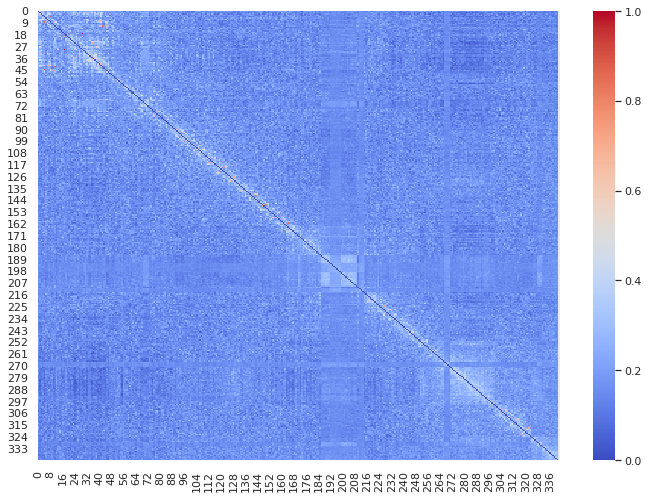

In [59]:
def visualise_ccmpred(ccmpredmat: str):
    ar = np.genfromtxt(ccmpredmat, delimiter='\t')
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.heatmap(ar, cmap='coolwarm')
visualise_ccmpred('./all_filtered_from_singletons_and_noccds_vs_r751/ccmpred.out')

### DSSP if needed

In [18]:
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
dssp_dict, keys = dssp_dict_from_pdb_file('./all_filtered_from_singletons_and_noccds_vs_r751/contactmap_mapped_attached.pdb')
acceptable_ss = ['E', 'H']
sse_residues = ""
for key in keys:
    residue = key[1][1]
    ss = dssp_dict[key][1]
    if ss in acceptable_ss:
        sse_residues += ":"
        sse_residues += str(residue)
        sse_residues += ","
print(sse_residues)

:5,:6,:7,:8,:9,:10,:11,:12,:13,:14,:15,:16,:17,:18,:24,:25,:26,:27,:28,:29,:30,:31,:36,:37,:38,:39,:40,:41,:42,:43,:44,:45,:46,:47,:48,:49,:50,:51,:63,:64,:65,:66,:67,:68,:69,:72,:73,:74,:75,:76,:77,:78,:79,:80,:81,:82,:83,:84,:85,:86,:87,:88,:89,:90,:91,:92,:93,:94,:95,:96,:97,:98,:99,:100,:101,:102,:103,:104,:105,:106,:107,:108,:109,:110,:111,:112,:113,:114,:115,:116,:117,:118,:119,:120,:121,:122,:123,:124,:125,:126,:127,:128,:129,:130,:131,:132,:133,:134,:135,:136,:137,:138,:139,:140,:141,:142,:143,:144,:145,:146,:147,:148,:149,:150,:151,:158,:159,:160,:161,:162,:163,:164,:165,:166,:167,:168,:169,:170,:171,:177,:178,:179,:180,:181,:182,:183,:189,:190,:191,:192,:193,:194,:195,:196,:197,:198,:199,:200,:201,:202,:203,:204,:216,:217,:218,:219,:220,:221,:222,:224,:225,:226,:227,:228,:229,:230,:231,:232,:233,:234,:235,:236,:237,:238,:239,:240,:241,:242,:243,:244,:245,:246,:247,:248,:249,:250,:251,:252,:253,:254,:255,:256,:257,:258,:259,:260,:261,:262,:263,:264,:265,:266,:267,:268,:269,:27

In [53]:
import re
file = open('kamil.pdb')
for line in file:
    if line.startswith('HET'):
        print(line)

TypeError: startswith() takes at least 1 argument (0 given)